In [1]:
from ProcessingEmbeddings import *
from HardDebias import *
from DoubleHardDebias import *
from utils import *

In [2]:
import codecs
import json
import numpy as np
import sklearn
from sklearn.svm import LinearSVC, SVC


In [3]:
glove=Embeddings('glove-wiki-gigaword-50')

Loading glove-wiki-gigaword-50 embeddings
vectors shape: (400000, 50), word2idx length: 400000, vocab length: 400000


In [4]:
vectors=glove.vectors
word2idx=glove.word2idx
vocab=glove.words
dict_vectors = glove.get_word_vector_dict()

In [5]:
np.isnan(vectors).any()

False

In [6]:
#Gender specific vocabulary:
gender_specific=[]
with open('./Data/male_word_file.txt') as f:
    gender_specific = [line.strip() for line in f]

with open('./Data/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

with codecs.open('./Data/gender_specific_full.json') as f:
    gender_specific.extend(json.load(f))

In [7]:
# Getting a limited vocabulary to debias the embeddings.
vocab_cleaned, vectors_cleaned, word2idx_cleaned, dict_vec_cleaned = glove.limit_vocab(vectors, word2idx, vocab, exclude=gender_specific)

100%|██████████| 400000/400000 [00:00<00:00, 621870.34it/s]


Size of limited vocabulary: 326614


In [8]:
#Getting the definitional sets to calculate afterwards the gender direction. The first 10 gender sets were proposed by Bolukbasi et al. (2016)
#Definitional sets for race where proposed by Manzini et al. in Multiclass debiasing of embeddings: https://github.com/TManzini/DebiasMulticlassWordEmbedding/blob/master/Debiasing/data/vocab/race_attributes_optm.json

def_sets={
    "gender" : [
    ['she', 'he'], ['herself', 'himself'], ['her', 'his'], ['daughter', 'son'], ['girl', 'boy'],
    ['mother', 'father'], ['woman', 'man'], ['mary', 'john'], ['gal', 'guy'], ['female', 'male'],['aunt', 'uncle']],
    
    "race":[
		["black", "caucasian", "asian"],
		["african", "caucasian", "asian"],
		["black", "white", "asian"],
		["africa", "america", "asia"],
		["africa", "america", "china"],
		["africa", "europe", "asia"]
    ], 
    "religion":[
		["judaism", "christianity", "islam"],
		["jew", "christian", "muslim"],
    ["synagogue", "church", "mosque"],
    ["torah", "bible", "quran"],
    ["rabbi", "priest", "imam"]
	]}

In [9]:
#Equalizing pairs for gender debiasing were first published by Bolukbasi et al. in https://github.com/tolga-b/debiaswe/blob/master/data/equalize_pairs.json
# Equalizing sets for race and religion where defined by Manzini as equal to the defining set (Manzini et al., 2019.p.3)
equalizing_lists = {
    "gender": [
        ["monastery", "convent"], ["spokesman", "spokeswoman"], ["Catholic_priest", "nun"], ["Dad", "Mom"], ["Men", "Women"],
        ["councilman", "councilwoman"], ["grandpa", "grandma"], ["grandsons", "granddaughters"], ["prostate_cancer", "ovarian_cancer"],
        ["testosterone", "estrogen"], ["uncle", "aunt"], ["wives", "husbands"], ["Father", "Mother"], ["Grandpa", "Grandma"],
        ["He", "She"], ["boy", "girl"], ["boys", "girls"], ["brother", "sister"], ["brothers", "sisters"], ["businessman", "businesswoman"],
        ["chairman", "chairwoman"], ["colt", "filly"], ["congressman", "congresswoman"], ["dad", "mom"], ["dads", "moms"], ["dudes", "gals"],
        ["ex_girlfriend", "ex_boyfriend"], ["father", "mother"], ["fatherhood", "motherhood"], ["fathers", "mothers"], ["fella", "granny"],
        ["fraternity", "sorority"], ["gelding", "mare"], ["gentleman", "lady"], ["gentlemen", "ladies"], ["grandfather", "grandmother"],
        ["grandson", "granddaughter"], ["he", "she"], ["himself", "herself"], ["his", "her"], ["king", "queen"], ["kings", "queens"],
        ["male", "female"], ["males", "females"], ["man", "woman"], ["men", "women"], ["nephew", "niece"], ["prince", "princess"], 
        ["schoolboy", "schoolgirl"], ["son", "daughter"], ["sons", "daughters"], ["twin_brother", "twin_sister"]],

    "race": [
        ["black", "caucasian", "asian"],
      	["african", "caucasian", "asian"],
      	["black", "white", "asian"],
      	["africa", "america", "asia"],
      	["africa", "america", "china"],
      	["africa", "europe", "asia"]
    ],
    "religion": [
        ["judaism", "christianity", "islam"],
        ["jew", "christian", "muslim"],
        ["synagogue", "church", "mosque"],
        ["torah", "bible", "quran"],
        ["rabbi", "priest", "imam"]
    ]}


### Hard-Debias Algorithm

#### Gender

In [10]:
def prepare_def_sets_subspace(list_def_sets):
  def_sets={i: v for i, v in enumerate(list_def_sets)}
  return def_sets

In [11]:
def_set_gender=utils.prepare_def_sets_subspace(def_sets["gender"])
def_set_race=utils.prepare_def_sets_subspace(def_sets["race"])
def_set_religion=utils.prepare_def_sets_subspace(def_sets["religion"])

In [12]:
import HardDebias as hd

In [12]:
debiased_vectors, debiased_vocab, debiased_word2idx= hard_debias(vectors,
                             dict_vectors, 
                             word2idx_cleaned,
                             vocab_cleaned, 
                             equalizing_lists['gender'], 
                             def_set_gender,
                             1,
                             centralizing=False)

Length of vectors set: 11
Running PCA with 1 components


In [13]:
debiased_dict=get_debiased_dict(debiased_vectors, debiased_word2idx)

## Evaluation

In [14]:
from Visualization import *

In [15]:
# To compute the gender bias, we need to get the embeddings of "he" and "she"
he_embed = dict_vectors['he']
she_embed = dict_vectors['she']

# Using the gender bias function to compute the bias of all the words in the limited dataset
#We create a dictionary with the word as key and the bias as value
gender_bias_original = utils.compute_bias(dict_vec_cleaned, he_embed, she_embed)

In [16]:
gender_bias_after_debiasing=utils.compute_bias(debiased_dict, he_embed, she_embed)

In [17]:
occupations = ['assistant','secretary','data scientist', 'scientist', 'politician','janitor', 'hairdresser','teacher', 'bartender','midwife','doctor','ballerina','dancer','pediatrician','surgeon', 'physician', 'shopkeeper',  'nurse', 'interior designer', 'architect', 'maid', 'housekeeper', 'soprano', 'baritone', 'servant',  'vocalists', 'guitarists','carpenter','clerk','manager','supervisor','driver','software developer','lawyer','pitcher', 'bookkeeper', 'infielder', 'receptionist', 'investigator', 'pundit', 'chancellor', 'maestro','lecturer','salesperson','homemaker', 'receptionist','librarian', 'nanny', 'bookkeeper', 'stylist','housekeeper','guidance counselor','skipper', 'protege','philosopher','captain', 'architect', 'financier', 'warrior', 'broadcaster', 'magician', 'figher','pilot', 'boss']


In [18]:
bias_df=get_bias_score_df_from_list(gender_bias_original,gender_bias_after_debiasing, occupations,vocab_cleaned,debiased_vocab)
plot_bias_bar(bias_df)

In [20]:
c_w2i, c_vocab, female_words, male_words, y_true=getting_biased_words(gender_bias_original, def_sets['gender'], 1000, word2idx)


In [21]:
def extract_vectors(words, vectors, w2i):

    X = [vectors[w2i[x], :] for x in words]

    return X


In [22]:
def visualize(vectors, y_true, y_pred, ax, title):
    # perform TSNE
    vectors = utils.normalize(vectors)
    X_embedded = TSNE(
        n_components=2, random_state=RANDOM_STATE).fit_transform(vectors)
    for x, p, y in zip(X_embedded, y_pred, y_true):
        if y:
            ax.scatter(x[0], x[1], marker='.', c='c')
        else:
            ax.scatter(x[0], x[1], marker='x', c='darkviolet')

    return ax


In [63]:
def cluster_and_visualize(words, X1, title, y_true, num=2):

    kmeans_1 = KMeans(n_clusters=num, random_state=RANDOM_STATE).fit(X1)
    y_pred_1 = kmeans_1.predict(X1)
    correct = [1 if item1 == item2 else 0 for (
        item1, item2) in zip(y_true, y_pred_1)]
    print('precision', max(sum(correct)/float(len(correct)),
          1 - sum(correct)/float(len(correct))))

    fig, axs = plt.subplots(1, 1, figsize=(6, 3))
    ax1 = visualize(X1, y_true, y_pred_1, axs, title)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 1.0


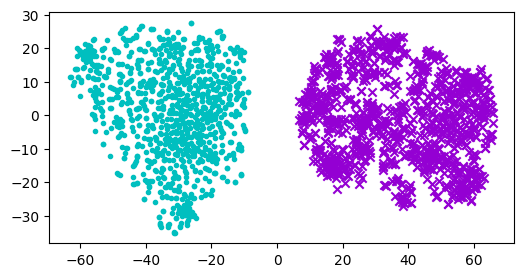

In [23]:
gendered_vectors=utils.extract_vectors(male_words + female_words, vectors_cleaned, word2idx_cleaned)
cluster_and_visualize(male_words + female_words,
                      gendered_vectors, 'GloVe_original', y_true)


/Users/angeladuarte/opt/miniconda3/envs/MT_env/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



precision 0.511


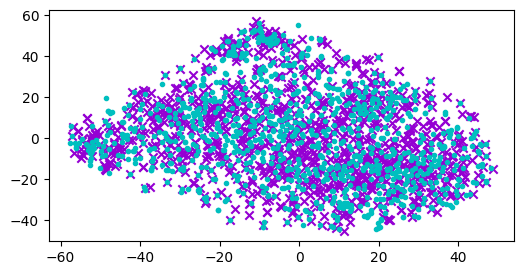

In [25]:
gendered_debiased_vectors = utils.extract_vectors(
    male_words + female_words, debiased_vectors, debiased_word2idx)

cluster_and_visualize(male_words + female_words, gendered_debiased_vectors,
                      'Debiased_GloVe', y_true)


###  Double-Hard Debias

In [ ]:

biased_w2i, biased_vocab, female_words, male_words, y_true = utils.getting_biased_words(
    gender_bias_original, def_sets["def_sets_gender"], 1000, word2idx_cleaned)
np.isnan(vectors).any()
precisions, optimal_direction = getting_optimal_direction(
    vectors, word2idx, biased_w2i, biased_vocab, male_words, female_words, y_true, def_sets["def_sets_gender"])
dh_debiased_vectors = double_hard_debias(vectors, word2idx, word2idx, vocab, [
                                         optimal_direction], def_sets["def_sets_gender"])
dh_debiased_vocab_limited, dh_debiased_vectors_limited, dh_debiased_word2idx_limited = glove.limit_vocab(
    dh_debiased_vectors, word2idx, vocab, exclude=gender_specific)
